# Text Alignment Pipeline

In [10]:
import pymorphy2
import re
import torch
import seaborn as sns
import numpy as np
import razdel

from scipy import spatial
from matplotlib import pyplot as plt
from transformers import AutoTokenizer, AutoModelWithLMHead

In [2]:
import os

pattern_ru_orig = re.compile(r'[a-zA-Z\(\)\[\]\/\<\>•\'\n]+')
double_spaces = re.compile(r'[\s]+')
double_commas = re.compile(r'[,]+')
double_dash = re.compile(r'[-—]+')
pattern_zh = re.compile(r'[」「“”„‟\x1a⓪①②③④⑤⑥⑦⑧⑨⑩⑴⑵⑶⑷⑸⑹⑺⑻⑼⑽*a-zA-Zа-яА-Я\(\)\[\]\s\n\/\-\:•＂＃＄％＆＇（）＊＋－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》【】〔〕〖〗〘〙〜〟〰〾〿–—‘’‛‧﹏〉]+')
pat_comma = re.compile(r'[\.]+')
first_numbers = re.compile(r'^[0-9,\.]+')
last_punct = re.compile(r'[,\.]+$')
multiple_spaces = re.compile(r'\s+')
pattern_ru = re.compile(r'[a-zA-Z\.\(\)\[\]\/\-\:!?\<\>;•\"\'«»——,]+')
pattern_ru_letters_only = re.compile(r'[^а-яА-Я\s]+')

def split_zh(paragraph):
    for sent in re.findall(u'[^!?。！？\.\!\?]+[!?。！？\.\!\?]?', paragraph, flags=re.U):
        yield sent
            
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
model = AutoModelWithLMHead.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

def get_sent_vec(text):
    tokenized_text = tokenizer.encode(text, add_special_tokens=True)
    #indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor(tokenized_text).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        return model(tokens_tensor)[0]

#лемматизация
morph = pymorphy2.MorphAnalyzer()

def get_file_vectors(path_ru):
    ru_vectors = []
    with open(path_ru, mode="r", encoding="utf-8") as input_ru:
        for line_ru in input_ru.readlines():
            line_ru = re.sub(pattern_ru, '', line_ru).strip()
            line_ru = re.sub(last_punct, '', line_ru).strip()
            line_ru = re.sub(first_numbers, '', line_ru).strip()
            line_ru = re.sub(multiple_spaces, ' ', line_ru).strip()
            line_ru = line_ru.lower()

            line_ru = ' '.join(list(map(lambda x: morph.parse(x)[0].normal_form, line_ru.split())))
            #print(line_ru)
            ru_vectors.append(get_sent_vec(line_ru))
    return ru_vectors

def get_line_vectors(lines):
    ru_vectors = []
    for line_ru in lines:
        line_ru = re.sub(pattern_ru, '', line_ru).strip()
        line_ru = re.sub(last_punct, '', line_ru).strip()
        line_ru = re.sub(first_numbers, '', line_ru).strip()
        line_ru = re.sub(multiple_spaces, ' ', line_ru).strip()
        line_ru = line_ru.lower()

        line_ru = ' '.join(list(map(lambda x: morph.parse(x)[0].normal_form, line_ru.split())))
        #print(line_ru)
        ru_vectors.append(get_sent_vec(line_ru))
    return ru_vectors

In [5]:
def get_pairs(ru_lines, zh_lines, ru_proxy_lines, sim_matrix, threshold):
    ru = []
    zh = []
    ru_proxy = []
    sims = []
    for i in range(sim_matrix.shape[0]):
        for j in range(sim_matrix.shape[1]):
            if sim_matrix[i,j] >= threshold:
                ru.append(ru_lines[j])
                zh.append(zh_lines[i])
                ru_proxy.append(ru_proxy_lines[i])
                sims.append(sim_matrix[i,j])
                
    return ru,zh,ru_proxy,sims

def get_sim_matrix(ru_vec, ru_vec2, window=10):
    sim_matrix=np.zeros((len(ru_vec), len(ru_vec2)))
    k = len(ru_vec)/len(ru_vec2)
    for i in range(len(ru_vec)):
        for j in range(len(ru_vec2)):
            if (j*k > i-window) & (j*k < i+window):
                sim = 1 - spatial.distance.cosine(ru_vec[i][0,-1,:], ru_vec2[j][0,-1,:])
                sim_matrix[i,j] = sim

    return sim_matrix  

def align_texts(base_path, file_ru, file_zh, threshold, batch_size=50, window=10, n_gram=1, n_gram_sent_max_words=20, l_diff=0.8, debug=False, vectors_ru1=None, vectors_ru2=None):
    
    splitted_ru = os.path.join(base_path, "splitted", os.path.basename(file_ru))
    splitted_zh = os.path.join(base_path, "splitted", os.path.basename(file_zh))
    proxy_ru = os.path.join(base_path, "proxy", os.path.basename(file_ru))    
    ngramed_splitted_zh = os.path.join(base_path, "gramed", os.path.basename(file_zh))
    ngramed_proxy_ru = os.path.join(base_path, "gramed", os.path.basename(file_ru))    
    output_ru = os.path.join(base_path, "done", os.path.basename(file_ru))
    output_zh = os.path.join(base_path, "done", os.path.basename(file_zh))
    
    print("Splitting ru.")
    with open(file_ru, mode='r', encoding='utf-8') as input_ru, open(splitted_ru, mode='w', encoding='utf-8') as out_ru:
        ru = ' '.join(input_ru.readlines())
        ru = re.sub(pattern_ru_orig, '', ru)
        ru = re.sub(double_spaces, ' ', ru)
        ru = re.sub(double_commas, ',', ru)
        ru = re.sub(double_dash, '—', ru)

        sent_ru = list(x.text for x in razdel.sentenize(ru))

        count = 1
        for x in sent_ru:
            if count < len(sent_ru)-1:
                out_ru.write(x.strip() + "\n")
            else:
                out_ru.write(x.strip())
            count += 1
            
    print("Russian text lines:", len(sent_ru), "\n")
    
    print("Splitting zh.")
    with open(file_zh, mode='r', encoding='utf-8') as input_zh, open(splitted_zh, mode='w', encoding='utf-8') as out_zh:
        zh = ''.join(input_zh.readlines())    
        zh = re.sub(pat_comma, '。', zh)

        sent_zh = list(re.sub(pattern_zh,'',x.strip()) for x in split_zh(zh))

        count = 1
        for x in sent_zh:
            if count < len(sent_zh)-1:
                out_zh.write(x.strip() + "\n")
            else:
                out_zh.write(x.strip())
            count += 1

    print("Chinese text lines:", len(sent_zh), "\n")    
    
    #check if proxy file exists
    if not(os.path.isfile(proxy_ru)):
        raise Exception("Proxy file not found:", proxy_ru)
    
    print("Proxy file is found:")
    print(proxy_ru + "\n")
    
    print("Creating ngrammed by sentence text files...")
    #ngramming
#     max_sent_words = 20 #don't process very long sentences.
    count_ngramed = 0
    with open(splitted_zh, mode="r", encoding="utf-8") as input_zh, \
         open(proxy_ru, mode="r", encoding="utf-8") as input_proxy, \
         open(ngramed_splitted_zh, mode='w', encoding='utf-8') as ngram_zh, \
         open(ngramed_proxy_ru, mode='w', encoding='utf-8') as ngram_ru:
        lines_zh = input_zh.readlines()
        lines_ru_proxy = input_proxy.readlines()
        file_len = len(lines_ru_proxy)
        
        for i in range(file_len):
            #process sentence
            #always write original sentence
            ngram_ru.write(lines_ru_proxy[i].strip() + "\n")
            ngram_zh.write(lines_zh[i].strip() + "\n")
            count_ngramed += 1
            #add ngamed sentences
            for k in range(1, n_gram):
                #write if every sentence is longer than max_sent_words
                to_write = True
                line_ru = ""
                line_zh = ""
                for j in range(k+1):
                    if (len(re.sub(pattern_ru_letters_only,'',lines_ru_proxy[min(i+j, file_len-1)]).split())>n_gram_sent_max_words):
                        to_write = False
                    line_ru += lines_ru_proxy[min(i+j, file_len-1)].strip()
                    line_ru += " "
                    
                    line_zh += lines_zh[min(i+j, file_len-1)].strip()
                    
                    #ngram_ru.write(lines_ru_proxy[min(i+j, file_len-1)].strip() + " ")
                    #ngram_zh.write(lines_zh[min(i+j, file_len-1)].strip() + " ")
                if to_write:
                    ngram_ru.write(line_ru + "\n")
                    ngram_zh.write(line_zh + "\n")
                    count_ngramed += 1
                    #ngram_zh.write("\n")
    
    
    
    print("Ngrammed Chinese text lines:", count_ngramed, "\n")   
#     raise Exception("debug")
    
    #batching    
    with open(splitted_ru, mode="r", encoding="utf-8") as input_ru, \
         open(ngramed_splitted_zh, mode="r", encoding="utf-8") as input_zh, \
         open(ngramed_proxy_ru, mode="r", encoding="utf-8") as input_proxy:
        lines_ru = input_ru.readlines()
        lines_zh = input_zh.readlines()
        lines_ru_proxy = input_proxy.readlines()    
    
    batch_number = 0
    total_pairs = 0
    with open(output_ru, mode='w', encoding='utf-8') as out_ru, open(output_zh, mode='w', encoding='utf-8') as out_zh:
        for lines_ru_batch, lines_ru_proxy_batch, lines_zh_batch in get_batch(lines_ru, lines_ru_proxy, lines_zh, batch_size):
            batch_number += 1

            #print(lines_ru_batch)
            
            print("--------------------------------------")
            print("batch:", batch_number, "[", (batch_number-1) * batch_size, "-", batch_number * batch_size, "]", "Calculating vectors...")
            vectors_ru1 = get_line_vectors(lines_ru_proxy_batch)
            vectors_ru2 = get_line_vectors(lines_ru_batch)
            
#             if vectors_ru1 is None:
#                 vectors_ru1 = get_line_vectors(lines_ru_proxy_batch)
#             if vectors_ru2 is None:
#                 vectors_ru2 = get_line_vectors(lines_ru_batch)

            print("Calculating similarity matrix...")
            sim_matrix = get_sim_matrix(vectors_ru1, vectors_ru2, window)  

            plt.figure(figsize=(12,10))
            sns.heatmap(sim_matrix,cmap="Greens", vmin=threshold)
            plt.show()
            
            count = 0
            for i in range(sim_matrix.shape[0]):
                for j in range(sim_matrix.shape[1]):
                    if sim_matrix[i,j] >= threshold:
                        count += 1
            total_pairs += count
            print("\nPairs found:", count, "\n")
            print("\nTotal pairs found:", total_pairs, "\n")
            print("--------------------------------------")
            
            res_ru, res_zh, res_ru_proxy, sims = get_pairs(lines_ru_batch, lines_zh_batch, lines_ru_proxy_batch, sim_matrix, threshold)

            for x,y,z,s in zip(res_ru, res_zh, res_ru_proxy, sims):
                #filter if res and proxy length is differ to much
                x_len = len(re.sub(pattern_ru_letters_only,'',x).split())
                z_len = len(re.sub(pattern_ru_letters_only,'',z).split())
                xz_diff = min(x_len,z_len)/max(x_len,z_len)
                if debug:
                    print("----------------------------------------------------------------------------")
                    print("similarity:", s)
                    print("length diff:", xz_diff)
                    if xz_diff < l_diff:
                        print("[filtered]")
                    print("--------------------------------------")
                
                if (debug) | (xz_diff >= l_diff):
                    out_ru.write(x)
                    out_zh.write(y)                    
                    print(x)
                    print(z)
                    print(y)

    print("Done. Total pairs found:", total_pairs)
    
    return vectors_ru1, vectors_ru2

def get_batch(iter1, iter2, iter3, n):
    l1 = len(iter1)
    l3 = len(iter3)
    k = int(round(n * l3/l1))    
    kdx = 0 - k
    for ndx in range(0, l1, n):
        kdx += k
        yield iter1[ndx:min(ndx + n, l1)], iter2[kdx:min(kdx + k, l3)], iter3[kdx:min(kdx + k, l3)]

Splitting ru.
Russian text lines: 241 

Splitting zh.
Chinese text lines: 311 

Proxy file is found:
D:\ml\tap\proxy\chekhov_futlar_ru.txt

Creating ngrammed by sentence text files...
Ngrammed Chinese text lines: 402 

--------------------------------------
batch: 1 [ 0 - 100 ] Calculating vectors...
Calculating similarity matrix...


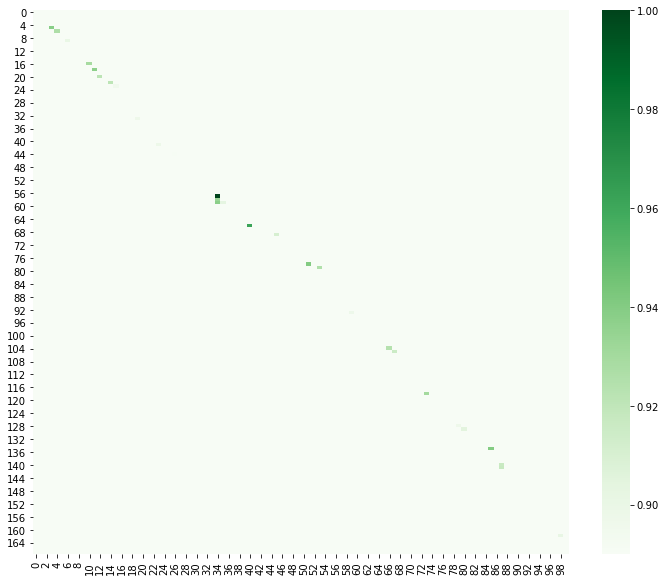


Pairs found: 29 


Total pairs found: 29 

--------------------------------------
Учитель же гимназии Буркин каждое лето гостил у графов П. и в этой местности давно уже был своим человеком.

Но Булкин, учитель средней школы, является гостем в доме графа каждое лето, и он уже хорошо знает этот район.

然而中学教师布尔金每年夏天都在伯爵家里做客，对这个地区早已熟透了。

Не спали.

Они не спали.

他们没睡觉。

Буркин лежал внутри на сене, и его не было видно в потемках.

Буркин лежал на сене в комнате, и никто не мог видеть его в темноте.

布尔金躺在房里的干草上，在黑暗里谁也看不见他。

Быть может, тут явление атавизма, возвращение к тому времени, когда предок человека не был еще общественным животным и жил одиноко в своей берлоге, а может быть, это просто одна из разновидностей человеческого характера,— кто знает?

Может быть, это генетическое явление межпоколенческого, и возвращение к бывшим предкам человека не животные, но живут в одиночку в своих пещерах этого явления, но, возможно, это всего лишь тип человеческого характера, кто знает?

也许这是隔代遗

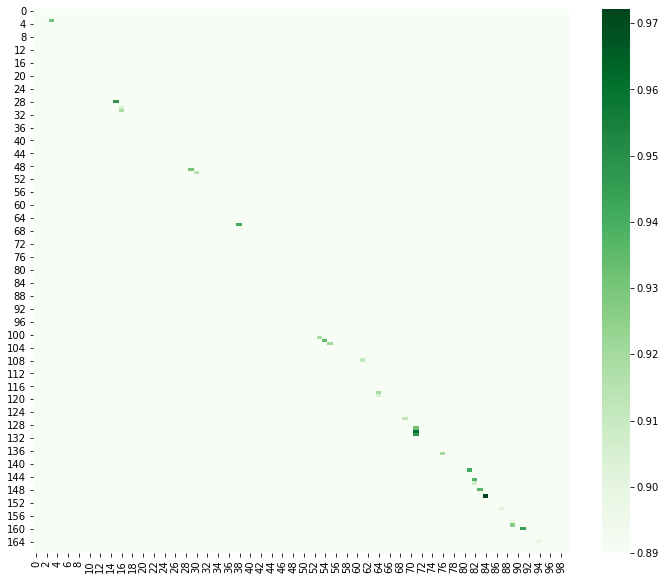


Pairs found: 30 


Total pairs found: 59 

--------------------------------------
Он поставил у себя на столе портрет Вареньки и все ходил ко мне и говорил о Вареньке, о семейной жизни, о том, что брак есть шаг серьезный, часто бывал у Коваленков, но образа жизни не изменил нисколько.

Он положил фотографию Вавринки на стол, постоянно приходил ко мне, рассказывал о Вавринке, рассказывал о семейной жизни, говорил о браке - это пожизненное мероприятие, часто ходил в дом Коваленко, но не менял свой образ жизни.

他把瓦连卡的照片放在自己桌子上，不断地来找我，谈瓦连卡，谈家庭生活，谈婚姻是终身大事，常到科瓦连科家去，可是他一点也没改变生活方式。

— Не понимаю,— говорил он нам, пожимая плечами,— не понимаю, как вы перевариваете этого фискала, эту мерзкую рожу.

Я не понимаю, он говорил нам, пожимая плечами, я не понимаю, как вы можете говорить с этим осведомителем, что отвратительно лицом вниз.

我不懂，他常对我们说，耸一耸肩膀，我不懂你们怎么能够跟这个告密的家伙，那副叫人恶心的嘴脸处得下去。

Эх, господа, как вы можете тут жить!

Увы! Как вы можете здесь жить, господа? 

唉！诸位先生，你们怎么能在这儿生活下去啊！

Эх, госпо

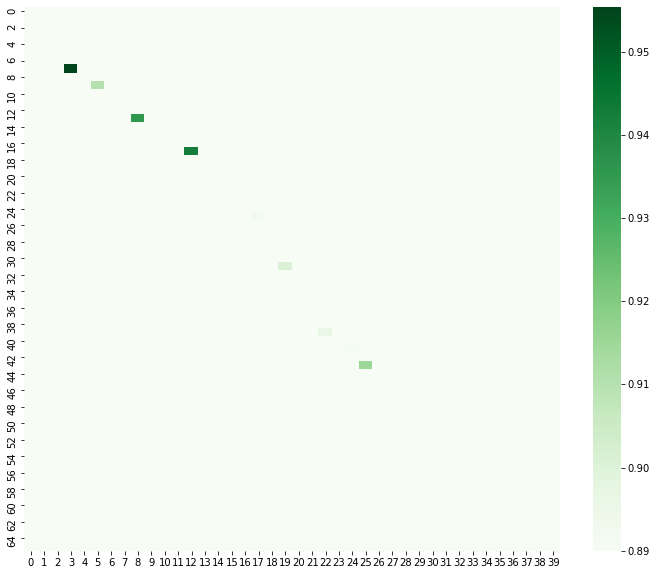


Pairs found: 10 


Total pairs found: 69 

--------------------------------------
Через месяц Беликов умер.

Через месяц Берыков умер.

过了一个月，别里科夫死了。

Теперь, когда он лежал в гробу, выражение у него было кроткое, приятное, даже веселое, точно он был рад, что, наконец, его положили в футляр, из которого он уже никогда не выйдет.

В это время он лежал в гробу, нежный и счастливый взгляд даже xing, как будто тайно рады, наконец, положить в рукав, никогда не придется выходить снова.

这时候他躺在棺材里，神情温和愉快甚至髙兴，仿佛暗自庆幸终于装进一个套子里，从此再也不必出来了似的。

Варенька тоже была на похоронах и, когда гроб опускали в могилу, всплакнула.

Вавринка тоже пошла на похороны, и когда гроб спустился в могилу, она плакала некоторое время.

瓦连卡也去送葬，等到棺材下了墓穴，她哭了一阵。

Ах, свобода, свобода!

, свобода, свобода!

啊，自由啊，自由！

— То—то вот оно и есть,—сказал Иван Иваныч и закурил трубку.

Вот в чем проблема, сказал Иван Иванех, и зажег трубку.

问题就在这儿，伊万伊万内奇说，点上了他的烟斗。

Учитель гимназии вышел из сарая.

Учительница средней школы вышл

In [11]:
base_path = r"D:\ml\tap"

file_ru = r"D:\ml\tap\raw\chekhov_futlar_ru.txt"
file_zh = r"D:\ml\tap\raw\chekhov_futlar_zh.txt"

v1, v2 = align_texts(base_path, file_ru, file_zh, threshold=0.89, batch_size=100, window=12, n_gram=2, \
                     n_gram_sent_max_words=12, l_diff=0.6, debug=False)

In [64]:
#v1, v2 = align_texts(file_ru, file_zh, 0.85, v1, v2)

In [12]:
v1

[tensor([[[-0.4043,  0.2026,  0.0409,  ...,  0.0145,  0.1794,  0.3236],
          [-0.6070,  0.0364, -0.1017,  ...,  0.1266,  0.2242,  0.4694],
          [-0.6847,  0.1367, -0.0845,  ...,  0.0269,  0.4575,  0.4933],
          ...,
          [-0.5485,  0.1111, -0.0447,  ..., -0.1415,  0.0405,  0.4020],
          [-0.5613, -0.0151, -0.0842,  ...,  0.0701,  0.1591,  0.4887],
          [-0.3915,  0.2432,  0.0633,  ..., -0.0427,  0.2058,  0.3735]]]),
 tensor([[[ 0.4283,  0.7431,  0.6421,  ..., -0.6751,  0.4634, -1.0836],
          [ 0.3015,  0.6458,  0.5444,  ..., -0.6355,  0.4047, -1.1767],
          [ 0.4862,  0.7460,  0.6695,  ..., -0.5531,  0.4937, -1.2332],
          ...,
          [ 0.5148,  0.7292,  0.6858,  ..., -0.5114,  0.5810, -1.0708],
          [ 0.4575,  0.8236,  0.7708,  ..., -0.5539,  0.4467, -1.0858],
          [ 0.4017,  0.7367,  0.5986,  ..., -0.6842,  0.5527, -1.0728]]]),
 tensor([[[ 0.2147,  0.3506,  0.6355,  ...,  0.4914,  1.4228,  0.1730],
          [ 0.2066,  0.4268,